In [57]:
from functools import partial
from samplers import exponential_kernel, BlackOutSampler, MeanSampler, BlurSampler, IdentitySampler, GrayOutSampler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as seg

from lime import ImageExplainer
from torchvision import models

from samplers import LatentSampler
from models import GLOW
import torch
from torchvision import transforms

import pickle


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
])

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_location='cpu'))

manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))
manipulators = torch.stack([v for k, v in manipulators.items()])

image = Image.open("./data/dog.jpg")
image = transform(image).numpy()
segmentation_fn = partial(seg.slic, n_segments=40, compactness=10)
kernel_fn = partial(exponential_kernel, kernel_width=0.25, distance_metric='cosine')
flow_sampler = partial(LatentSampler, kernel_fn=kernel_fn, model=flow, preprocessor=transform, manipulators=manipulators, radius=5)
black_out_sampler = partial(BlackOutSampler, kernel_fn=kernel_fn)
mean_sampler = partial(MeanSampler, kernel_fn=kernel_fn)
blur_sampler = partial(BlurSampler, kernel_fn=kernel_fn)
identity_sampler = partial(IdentitySampler, kernel_fn=kernel_fn)
gray_out_sampler = partial(GrayOutSampler, kernel_fn=kernel_fn)

model = models.resnet34(pretrained=True)
model.eval()

# get top 5 classes
with torch.no_grad():
    probs = model(torch.from_numpy(image).unsqueeze(0))
    probs = torch.nn.functional.softmax(probs, dim=1)
    top10 = torch.topk(probs, 10).indices.squeeze().numpy()

with open('data/imgnet_classes.txt', 'r') as f:
    classes = f.readlines()
    classes = [c.strip() for c in classes]

for i in top10:
    print(i, classes[i])

/tmp/ipykernel_679592/3686671150.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_

263 Pembroke
264 Cardigan
273 dingo
250 Siberian husky
248 Eskimo dog
272 coyote
249 malamute
274 dhole
271 red wolf
277 red fox


In [58]:
from evaluation import ZScoreMetric, PredictionDistributionMetric, DescriptiveAccuracy

segments = segmentation_fn(image.transpose(1, 2, 0))
sampler = gray_out_sampler(image, segments)
n_samples = 1000
activation_fn = torch.nn.functional.softmax

descriptive_acc_metric = DescriptiveAccuracy(image, 263, sampler, n_samples, model, segmentation_fn, transform, activation_fn)
descriptive_acc_metric.evaluate(progress=True)

Generating Samples: 100%|██████████| 1000/1000 [00:04<00:00, 246.06it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


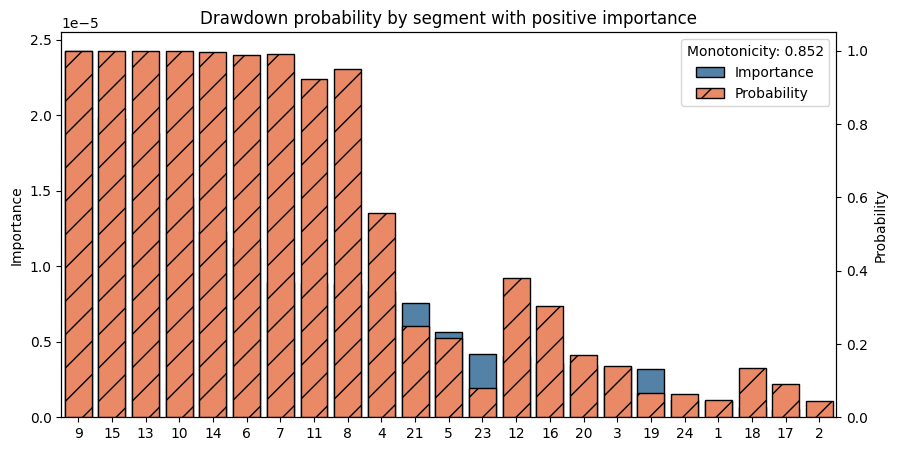

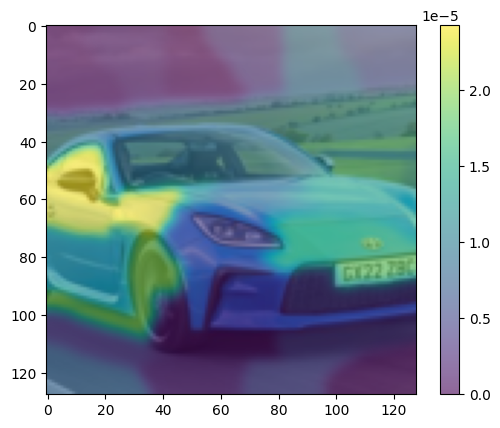

In [56]:
fig1 = descriptive_acc_metric.draw_down_plot()
fig2 = descriptive_acc_metric._explanation.render(type='smooth', positive_only=True)

In [4]:
descriptive_acc_metric.drawdown_probs

[0.0655929446220398,
 0.03544630855321884,
 0.018754133954644203,
 0.012433085590600967,
 0.009552796371281147,
 0.005955587141215801,
 0.004277239553630352,
 0.0032819141633808613,
 0.0017646132037043571,
 0.0019360395381227136,
 0.003374783555045724,
 0.0036914285738021135,
 0.003811880014836788,
 0.002918086713179946,
 0.002205460099503398,
 0.00209631584584713,
 0.0024789776653051376,
 0.0017923241248354316,
 0.0017458443762734532,
 0.001585617195814848,
 0.0015884276945143938,
 0.0016619451344013214,
 0.0017454595072194934,
 0.0016842104960232973,
 0.002567624906077981,
 0.002907636109739542,
 0.0030506879556924105,
 0.002949571004137397,
 0.0032322448678314686]

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

blackout_samples = black_out_sampler(image, segments).sample(n_samples)
mean_samples = mean_sampler(image, segments).sample(n_samples)
blur_samples = flow_sampler(image, segments).sample(n_samples)

perturbations = [s[1] for s in blackout_samples] + [s[1] for s in mean_samples] + [s[1] for s in blur_samples]

perturbations = [p.flatten() for p in perturbations]

pca_data = np.stack(perturbations)
pca.fit(pca_data)

blackout_pca = pca.transform(np.stack([s[1].flatten() for s in blackout_samples]))
mean_pca = pca.transform(np.stack([s[1].flatten() for s in mean_samples]))
blur_pca = pca.transform(np.stack([s[1].flatten() for s in blur_samples]))

Decoding: 100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [11]:
blur_samples[0][1].shape

(1, 3, 96, 96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0064138174..1.0536736].


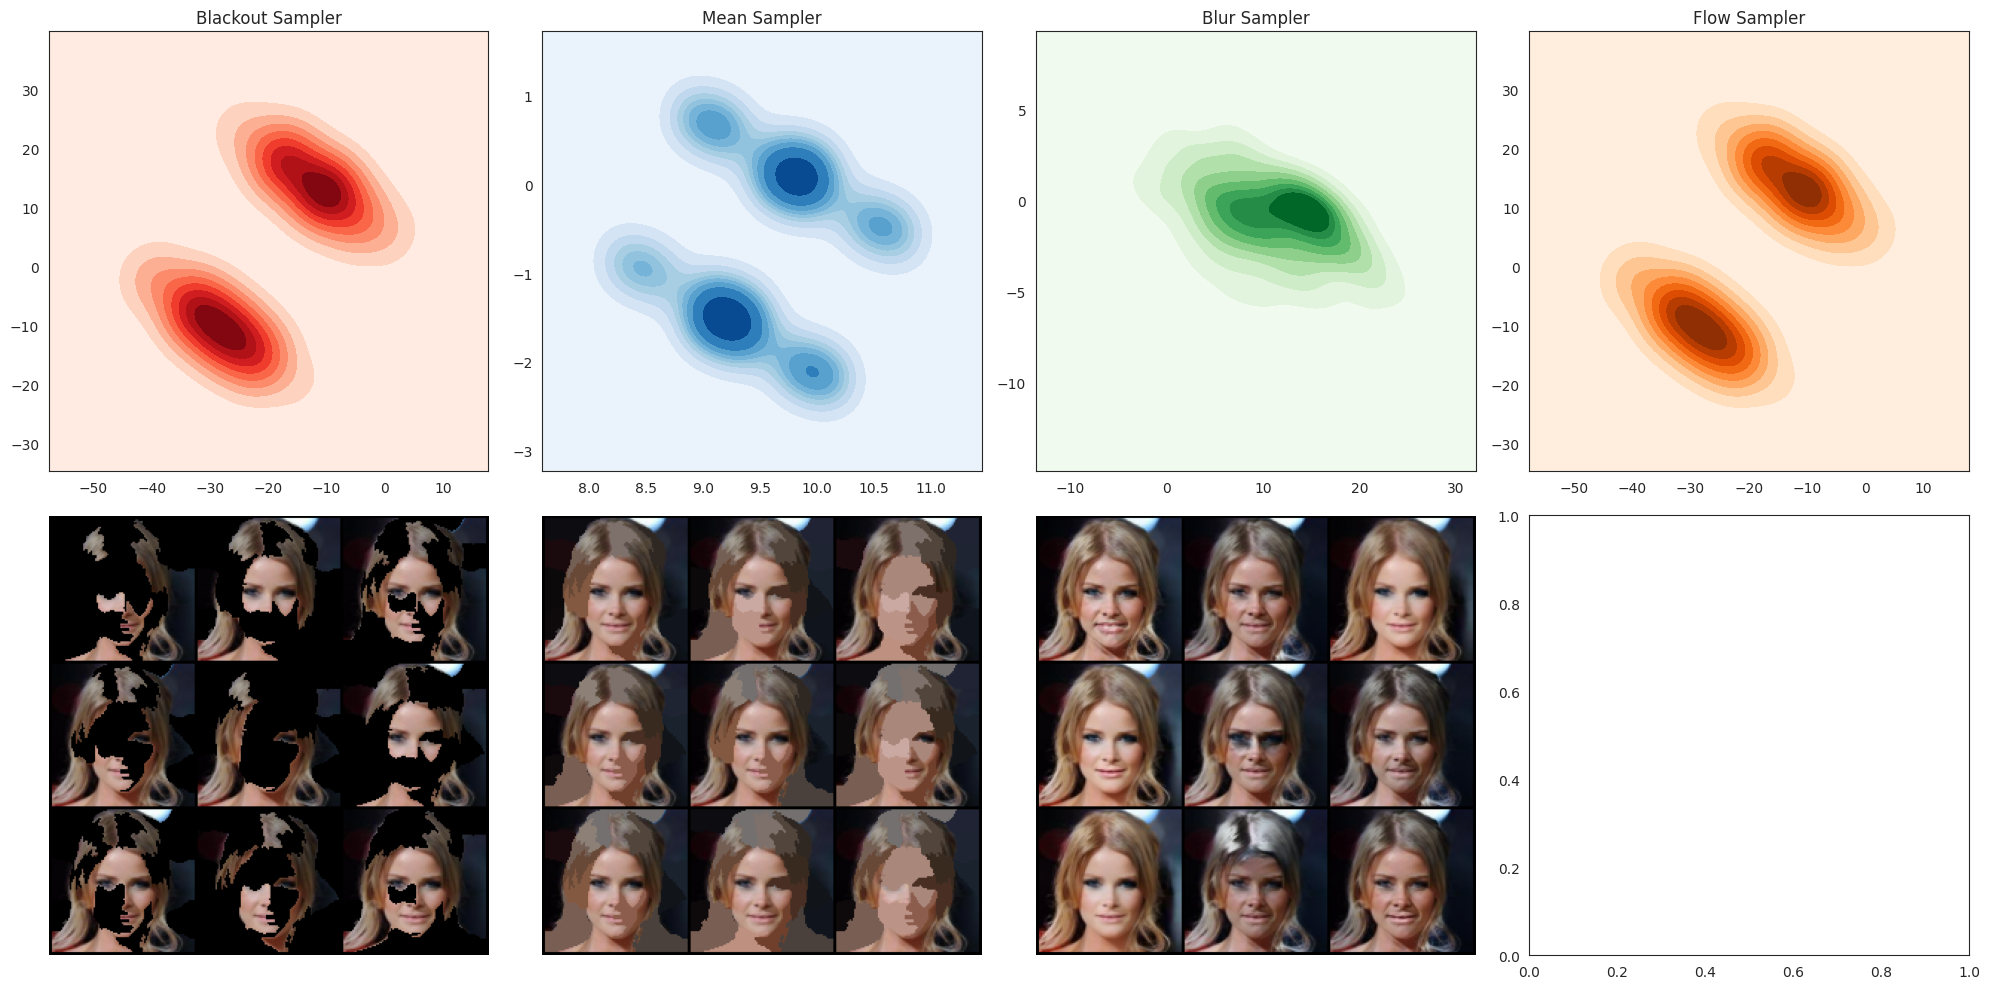

In [13]:
import seaborn as sns
from torchvision.utils import make_grid

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sns.set_style("white")

#sns.despine()
sns.kdeplot(x=blackout_pca[:, 0], y=blackout_pca[:, 1], fill=True, cmap='Reds', ax=axes[0, 0], thresh=0)
#sns.rugplot(x=blackout_pca[:, 0], y=blackout_pca[:, 1], ax=axes[0], color='red')
axes[0, 0].set_title('Blackout Sampler')
sns.kdeplot(x=mean_pca[:, 0], y=mean_pca[:, 1], fill=True,  cmap='Blues', ax=axes[0, 1], thresh=0)
#sns.rugplot(x=mean_pca[:, 0], y=mean_pca[:, 1], ax=axes[1], color='blue')
axes[0, 1].set_title('Mean Sampler')
sns.kdeplot(x=blur_pca[:, 0], y=blur_pca[:, 1], fill=True,  cmap='Greens', ax=axes[0, 2], thresh=0)
#sns.rugplot(x=blur_pca[:, 0], y=blur_pca[:, 1], ax=axes[2], color='green')
axes[0, 2].set_title('Blur Sampler')
sns.kdeplot(x=blackout_pca[:, 0], y=blackout_pca[:, 1], fill=True,  cmap='Oranges', ax=axes[0, 3], thresh=0)
#sns.rugplot(x=blackout_pca[:, 0], y=blackout_pca[:, 1], ax=axes[3], color='black')
axes[0, 3].set_title('Flow Sampler')

blackout_grid = make_grid([torch.tensor(s[1]) for s in blackout_samples[:9]], nrow=3)
mean_grid = make_grid([torch.tensor(s[1]) for s in mean_samples[:9]], nrow=3)
blur_grid = make_grid([torch.tensor(s[1]).squeeze(0) for s in blur_samples[:9]], nrow=3)

axes[1, 0].imshow(blackout_grid.permute(1, 2, 0))
axes[1, 0].axis('off')
axes[1, 1].imshow(mean_grid.permute(1, 2, 0))
axes[1, 1].axis('off')
axes[1, 2].imshow(blur_grid.permute(1, 2, 0))
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()